# Binary classification with Keras Sequential model

In this notebook we will build a binary classification model utilizing the [Keras Sequential model](https://www.tensorflow.org/guide/keras/sequential_model).

The sequential API is well suited for building models with layers that proceed in a sequential manner. This entails that the order of the layers matters.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from simple_keras import KerasSeqClassifier

2023-05-16 23:16:55.576211: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 23:16:55.630935: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 23:16:55.632170: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 23:16:56.551902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/hojve/repos/github/deep-learning/deep-learning-fundamentals/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as 

## Load data

We start by loading the `MNIST` dataset which contains images depicting hand-written numbers from 0-9.

In [2]:
# Split
split = ['train[:50%]', 'test[:50%]', 'test[50%:]']

# Load mnist dataset
(ds_train, ds_eval, ds_test), ds_info = tfds.load(
    name='mnist',
    split=split,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

## Inspect dataset

Start by inspecting the data. A TensorFlow `Dataset` has a lot of properties, for reference see [TensorFlow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Datasethttps://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [3]:
len(ds_train)

30000

In [4]:
# Print info
print(len(ds_train))
print(len(ds_eval))
print(len(ds_test))
print(ds_train.element_spec)

# Calculate number of classes in label
num_classes = ds_info.features['label'].num_classes
print(num_classes)

30000
5000
5000
(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
10


We can visualize some of the images.

2023-05-16 23:16:58.335981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-16 23:16:58.336930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-16 23:16:58.384394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{nod

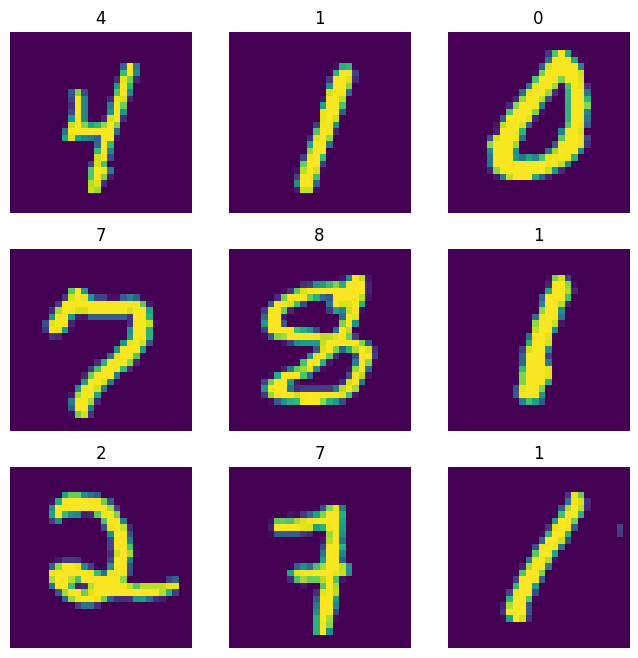

In [5]:
images_iter = iter(x_train for x_train, _ in ds_train.take(9).cache().repeat())
labels_iter = iter(y_train for _, y_train in ds_train.take(9).cache().repeat())
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

## Preprocess data

Before training we need to preprocess the images.

We start by normalizing the image pixels.

In [6]:
def normalize(image, label):
    """Normalize image pixels."""
    return tf.cast(image, tf.float32) / 255.0, label

In [7]:
# Normalize train and test data
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_eval = ds_eval.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
# Print element spec after preprocessing
print(ds_train.element_spec)
print(ds_eval.element_spec)
print(ds_test.element_spec)

(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


The shapes are the same, `(28, 28, 1)`, but the type has changed, `dtype=tf.float32`.

The `Dataset` API has some nice functionalities for speeding up the traning time.

By caching the datasets we we will save some operations (like file opening and data reading) from being executed during each epoch, [reference](https://www.tensorflow.org/guide/data_performance#caching).

### Set up training data

First, we take the training data and apply the following steps:
* cache it before shuffling for better performance
* for true randomness, set shuffle buffer to full dataset size
* batch elements of the dataset after shuffling to get unique batches at each epoch
* prefetch to increase performace

In [9]:
# Cache train data
ds_train = ds_train.cache()

# Shuffle data for true randomness and to reduce memory usage
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)

# Set batch size
ds_train = ds_train.batch(32)

# Prefetch
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


Second, we take our evaluation and test data. We do similar steps but skip a few:
* we don't need to shuffle the data
* caching is done after batching because batches can be the same between epochs

In [10]:

# Set batch size
ds_eval = ds_eval.batch(32)
ds_test = ds_test.batch(32)

# Cache test data
ds_eval = ds_eval.cache()
ds_test = ds_test.cache()

# Prefetch
ds_eval = ds_eval.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Train model

Next we instantiate the model and let it train for a number of epochs.

In [11]:
# Instantiate classifier
clf = KerasSeqClassifier(input_shape=(28, 28, 1))

In [12]:
# Train model
clf.call(ds_train=ds_train, ds_eval=ds_eval, epochs=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 34, 34, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        1600      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

2023-05-16 23:16:59.663620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-16 23:16:59.664195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
/home/hojve/repos/github/deep-learning/deep-learning-fundamentals/.venv/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?

937/938 [============================>.] - ETA: 0s - loss: 0.2126 - sparse_categorical_accuracy: 0.9360

2023-05-16 23:17:15.104604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-16 23:17:15.105183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


938/938 [==============================] - 16s 16ms/step - loss: 0.2125 - sparse_categorical_accuracy: 0.9360 - val_loss: 0.0980 - val_sparse_categorical_accuracy: 0.9682
Epoch 2/5
938/938 [==============================] - 14s 15ms/step - loss: 0.0782 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.0667 - val_sparse_categorical_accuracy: 0.9774
Epoch 3/5
938/938 [==============================] - 15s 16ms/step - loss: 0.0544 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.0619 - val_sparse_categorical_accuracy: 0.9794
Epoch 4/5
938/938 [==============================] - 16s 17ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.0765 - val_sparse_categorical_accuracy: 0.9748
Epoch 5/5
938/938 [==============================] - 15s 16ms/step - loss: 0.0347 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.0641 - val_sparse_categorical_accuracy: 0.9816


Next we evaluate on the test dataset which the model has never seen.

In [13]:
clf.model.evaluate(ds_test)

 17/157 [==>...........................] - ETA: 0s - loss: 0.0539 - sparse_categorical_accuracy: 0.9890

2023-05-16 23:18:16.047350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-05-16 23:18:16.048208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


157/157 [==============================] - 1s 6ms/step - loss: 0.0569 - sparse_categorical_accuracy: 0.9840


[0.056865885853767395, 0.984000027179718]

Our model performs as good on the test dataset as it does on the validation dataset. This is encouraging and we probably hasn't overfitted on the training dataset.